# Robot Execution Failure Dataset

In this ipython notebook we'll examine some common techniques used in time series analysis by applying them to an Robot execution failure dataset.

The dataset includes 5 sets [LP1 to LP5], each is a different learning problem for different failure types.
All features are numeric although they are integer valued only. Each feature represents a force or a torque measured after failure detection; each failure instance is characterized in terms of 15 force/torque samples collected at regular time intervals starting immediately after failure detection; The total observation window for each failure instance was of 315 ms.

The dataset is available here: https://archive.ics.uci.edu/ml/machine-learning-databases/robotfailure-mld/

The below code cell includes importing the necessary modules for the functionality of the code.

In [3]:
%matplotlib inline

from sklearn import datasets, preprocessing, cross_validation, feature_extraction
from sklearn import linear_model, svm, metrics, ensemble, tree, neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import csv
from __future__ import print_function
from scipy import stats
import statsmodels.api as sm
from collections import Counter
from sklearn.cross_validation import StratifiedKFold
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
import datetime as Datetime  

from IPython.display import Image, display
from sklearn.externals.six import StringIO

The files for dataset were available .data format which were then converted to .csv format using proper delimiters and then used for importing the data for further calculation.


The dataset now consists of 6 columns corresponding to the different force and torque readings, and 15 instances taken for each label over the time duration.
As a part of analyzing time series data we can start with importing the data for one of the failures and performing trend analysis and checking
for autocorrelation and partial correlation of the data.

## Visualization

Let us import the data suing the pd.read_csv command.
Further some preprocessing can be done to the data which takes 15 instances for each Label types.
A plot of the data variation for 6 attributes is shown below.

As it is time series relalted data we can see the attributes varying over time.So, later the data is analyzed for autocorrelation and partial corelation for one of its label which will be useful for further time series analysis.
Also trend analysis is an important part of time series data which helps us decrypt the trend,seasonality, residual componets of the data.
The seasonal decomposition module presents in statsmodels api of python helps us decompose our time series data into its different components.


 Displaying results for LP1 

(15, 1)
(15, 1)
(15, 1)
(15, 1)
(15, 1)
(15, 1)


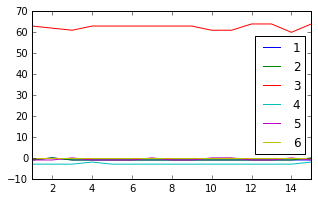

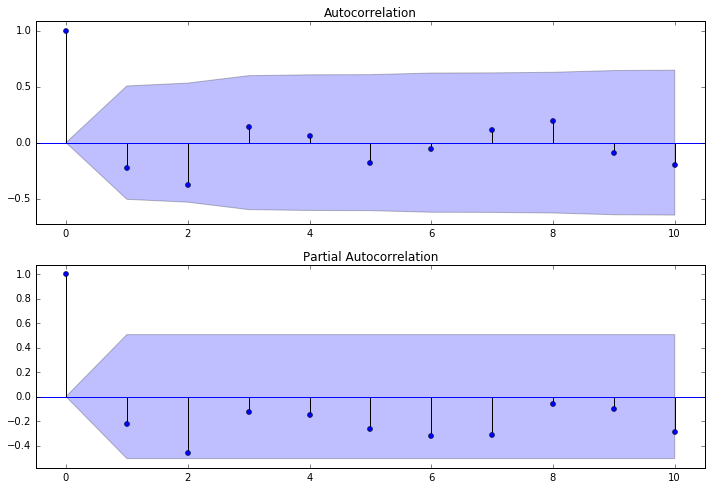

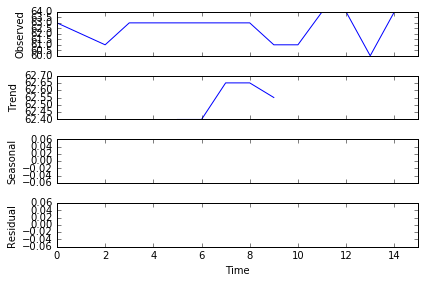

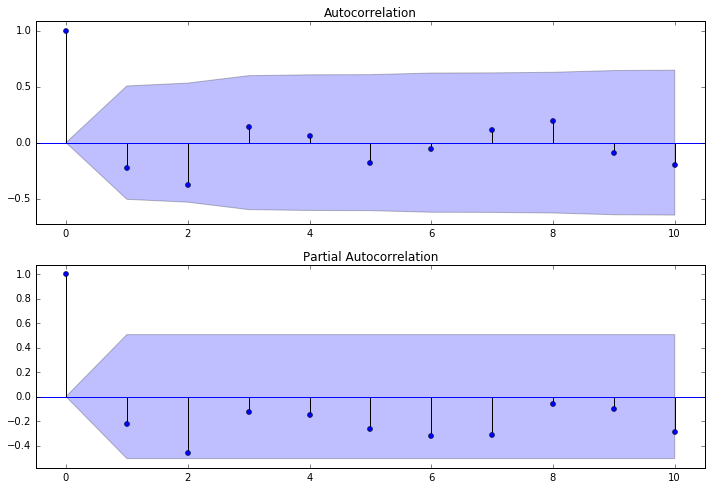

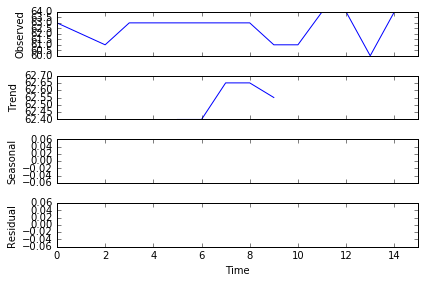

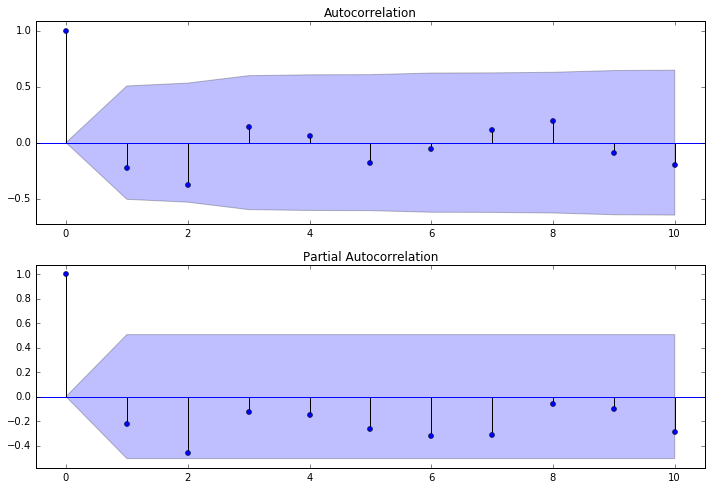

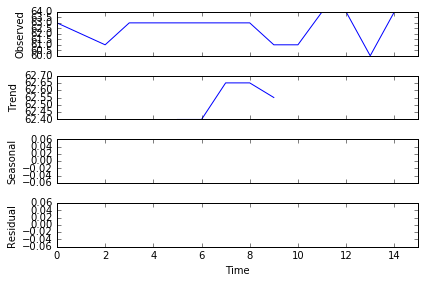

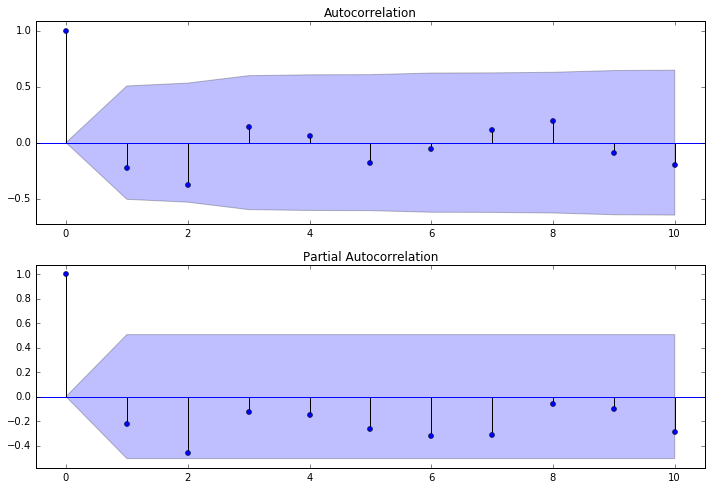

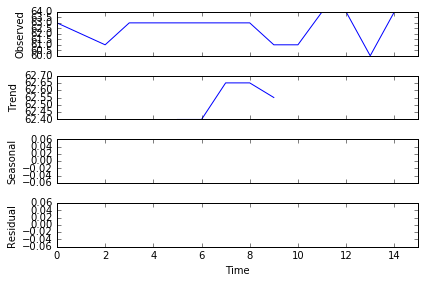

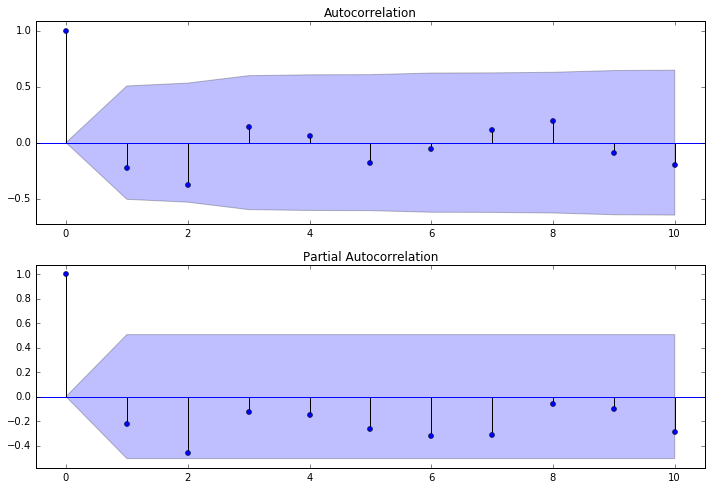

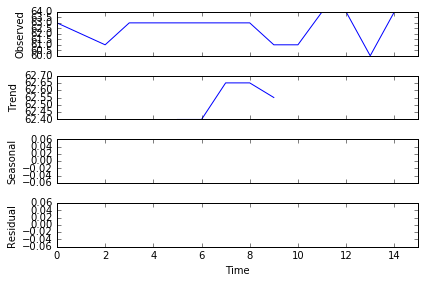

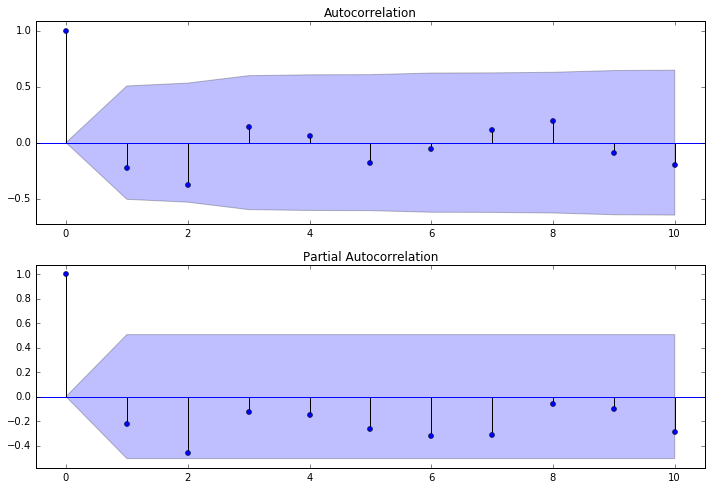

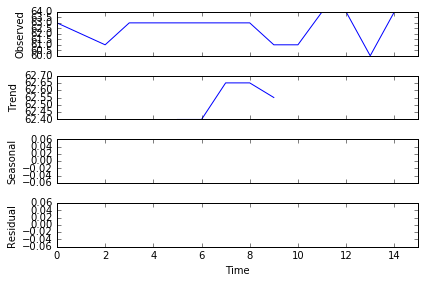

In [4]:
for i  in range(1,2,1):
    print("\n Displaying results for LP%d \n"%i)
    Robot_Fail= pd.read_csv("lp"+str(i)+".csv",skipinitialspace=True,names=["class", "1", "2", "3", "4", "5", "6"])
    #Preprocess the data to be used for further processing
    rows, cols = Robot_Fail.shape
    Robot_NEW=pd.DataFrame()
    ind=0
    for i in range(0,18,18):
        Robot_NEW.loc[ind,'class']=(Robot_Fail.ix[i,0])
        new=pd.DataFrame(Robot_Fail.iloc[i+1:i+16,1:7])
        new.plot(figsize=(5,3))
        ind2=0
        for m in range(0,6,1):
            new2=pd.DataFrame(new.iloc[:,2])
            print (new2.shape)
            fig = plt.figure(figsize=(12,8))
            ax1 = fig.add_subplot(211)
            fig = sm.graphics.tsa.plot_acf(new2.values.squeeze(), lags=10, ax=ax1)
            ax2 = fig.add_subplot(212)
            fig = sm.graphics.tsa.plot_pacf(new2.values, lags=10, ax=ax2)
            res = sm.tsa.seasonal_decompose(new2.values, freq=10)
            resi = res.plot()

The above plots derived for each attribute independently give us a lot of information on how the data depends on its past values and can be used in determining parameters for our further analysis.
Although we didn't plot them out here, the other lagged variables that we created above show similar results. There could be a relationship to other lag steps that we haven't tried, but it's impractical to test every possible lag value manually. But getting a feel for some of the attributes we finalized the degree of our ARMA model to be 1 as the data is captured for a very short interval and doesn't depend on its past values a lot.
Now that we have done the basic study of the basic study of the data,and as we see the time series data has some trend for some intervals.

## Data Mining

As derived from the various observations done above, let us get started with the actual classification problem.
Here we can import the data for all the 5 failures types.
As Time series are analyzed in order to understand the underlying structure and function that produce the observation here we take the 15 instances captured over 315 ms for 6 attributes for each label and get their ARMA co-efficients and constants.
So now instead of (15 X 6)=90 readings per label, we will have 2(constant,co-efficient) X 6 per label.
These coefficients derived can then be further used to fit the data using a classification model and compare the performances of different
models taking into account their accuracies.

Let us define some functions which can be used for each dataset for predictions.

Function for splitting the available data in train and test labels and data:

In [ ]:
def folds_to_split(data,targets,train,test):
    data_tr = pd.DataFrame(data).iloc[train]
    data_te = pd.DataFrame(data).iloc[test]
    labels_tr = pd.DataFrame(targets).iloc[train]
    labels_te = pd.DataFrame(targets).iloc[test]
    return [data_tr, data_te, labels_tr, labels_te]

Function for OneVsOne Classifier using logistic regression:

In [3]:
def oneVsOne_Classifier(data,targets):
    Robot_10stratified = StratifiedKFold(targets, n_folds=10,random_state=20160121, shuffle=True)
    lr = OneVsOneClassifier(linear_model.LogisticRegression())
    fold_results = pd.DataFrame()
    count = 0
    foldnum = 0
    for train, test in Robot_10stratified:
        foldnum+=1
        count+=1
        [Robot_tr_data, Robot_te_data,
         Robot_tr_target, Robot_te_target] = folds_to_split(data, targets,train,test) 
        lr.fit(Robot_tr_data.values, Robot_tr_target['class'].values)
    
        estimator_prediction = lr.estimators_[0].predict(Robot_te_data)
        prediction = lr.predict(Robot_te_data)
        acc = metrics.accuracy_score(prediction,Robot_te_target)
    
        print ("\nFold #%d -> Overall accuracy metric = %03.3f \t" % (foldnum, acc))
        fold_results.loc[count, 'Overall_accuracy'] = acc

    print ("\n Average values over 10 folds\n", fold_results.mean())

Function for OneVsRest Classifier using logistic regression:

In [4]:
def oneVsRest_Classifier(data,targets):
    Robot_10stratified = StratifiedKFold(targets, n_folds=10,random_state=20160121, shuffle=True)
    lr = OneVsRestClassifier(linear_model.LogisticRegression())
    fold_results = pd.DataFrame()
    count = 0
    foldnum = 0
    for train, test in Robot_10stratified:
        foldnum+=1
        count+=1
        [Robot_tr_data, Robot_te_data,
         Robot_tr_target, Robot_te_target] = folds_to_split(data, targets,train,test) 
        lr.fit(Robot_tr_data.values, Robot_tr_target['class'].values)
    
        estimator_prediction = lr.estimators_[0].predict(Robot_te_data)
        prediction = lr.predict(Robot_te_data)
        acc = metrics.accuracy_score(prediction,Robot_te_target)
    
        print ("\nFold #%d -> Overall accuracy metric = %03.3f \t" % (foldnum, acc))
        fold_results.loc[count, 'Overall_accuracy'] = acc

    print ("\n Average values over 10 folds\n", fold_results.mean())

Function for decision tree classifier over a range of depths:

In [8]:
def decisionTree_classifier(data,targets):
    dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='entropy')
    numberOfFold = 10
    Robot_10stratified = StratifiedKFold(targets, n_folds=numberOfFold, random_state=20160121, shuffle=True)
    print("where the `max_depth` parameter varies from 1 to 8")
    maxDepth = range(1,9)
    for i in maxDepth:
        accuracy = 0
        for trainVal, test in Robot_10stratified:
            #test has index value of all the instances chosen for testing, make a separate array for that
            [Robot_training4, Robot_validation4, Robot_training_labels4, Robot_validation_labels4] = folds_to_split(data,targets, trainVal, test)
            
            dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='entropy', max_depth = i)
            dtree.fit(Robot_training4, Robot_training_labels4);
            accuracy += dtree.score(Robot_validation4, Robot_validation_labels4);
            #to calculate error, we subtract accuracy from 1
            #accuracy divided by 4 since 4-Fold
        print ("maxDepth = {0} :: accuracy = {1}".format(i, (accuracy/numberOfFold)))

Function for K Nearest neighbour classifier over different parameters:

In [9]:
def KNN_classifier(data,targets):
    Robot_knn_results = pd.DataFrame()
    foldnum=0
    Robot_10stratified = StratifiedKFold(targets, n_folds=10,random_state=20160121, shuffle=True)
    for train, test in Robot_10stratified:
        foldnum+=1
        [Robot_tr_data, Robot_te_data, 
         Robot_tr_targets, Robot_te_targets] = folds_to_split(data,targets, train, test)
        # Give neighbors equal weight (uniform) or base weight on distance
        for weight in ['uniform', 'distance']:
            # Use 1, 2 or 15 neighbors to deteremine the class
            for k in [1, 5, 15]:
                #Use L1 (Manhattan), L2 (Euclidean), or L100 (approaching supremum distance)
                for degree in [1, 2, 100]:
                    knn = neighbors.KNeighborsClassifier(n_neighbors=k, p=degree, weights=weight)
                    knn.fit(Robot_tr_data.values, Robot_tr_targets.values.ravel())
                    Robot_knn_results.loc[foldnum, 
                                     'k={:<5}p={:<8}w={:<10}'.format(k, 
                                                                     degree, 
                                                                     weight)] = knn.score(Robot_te_data.values,
                                                                                       Robot_te_targets.values.ravel())
    print ("Results for different parameters of K-Nearest Neighbors")
    print (Robot_knn_results.mean().apply(lambda x : '%0.3f' % x))
    

## Load the data from different failure types, do the necessary preprocessing, apply auto regression on the same and apply different classification techniques to check for results.

In [15]:
for i  in range(1,6,1):
    print("\n Displaying results for LP%d \n"%i)
    Robot_Fail= pd.read_csv("lp"+str(i)+".csv",skipinitialspace=True,names=["class", "1", "2", "3", "4", "5", "6"])
    #Preprocess the data to be used for further processing
    rows, cols = Robot_Fail.shape
    Robot_NEW=pd.DataFrame()
    ind=0
    #print (rows)
    for i in range(0,rows,18):
        Robot_NEW.loc[ind,'class']=(Robot_Fail.ix[i,0])
        new=pd.DataFrame(Robot_Fail.iloc[i+1:i+16,1:7])
        #print (new)
        ind2=0
        for m in range(0,6,1):
            #print (m)
            new2=pd.DataFrame(new.iloc[:,m])
            #print (new2)
            #print (new2.values)
            try:
                arma=sm.tsa.ARMA(new2.values, (1,0)).fit()
                Robot_NEW.loc[ind, ind2] = arma.params[0] 
                ind2+=1
                Robot_NEW.loc[ind, ind2] = arma.params[1] 
            except np.linalg.linalg.LinAlgError as err:
                Robot_NEW.loc[ind, ind2] = 0 
                ind2+=1
                Robot_NEW.loc[ind, ind2] = 0
            ind2+=1
        ind+=1
    #print (Robot_NEW)
    Robot_attrs = Robot_NEW.iloc[:,1:]
    Robot_labels = Robot_NEW.iloc[:,0]
    print("\n Results for One Vs One Classifier using SVC: ")
    oneVsOne_Classifier(Robot_attrs,Robot_labels)
    print("\n Results for One Vs Rest Classifier using SVC: ")
    oneVsRest_Classifier(Robot_attrs,Robot_labels)
    print("\n Results for Decision tree clasifier: ")
    decisionTree_classifier(Robot_attrs,Robot_labels)
    print("\n Results for KNN classifier: ")
    KNN_classifier(Robot_attrs,Robot_labels)      


 Displaying results for LP1 


 Results for One Vs One Classifier using SVC: 

Fold #1 -> Overall accuracy metric = 0.636 	

Fold #2 -> Overall accuracy metric = 0.800 	

Fold #3 -> Overall accuracy metric = 0.700 	

Fold #4 -> Overall accuracy metric = 0.700 	

Fold #5 -> Overall accuracy metric = 0.667 	

Fold #6 -> Overall accuracy metric = 0.667 	

Fold #7 -> Overall accuracy metric = 0.875 	

Fold #8 -> Overall accuracy metric = 0.857 	

Fold #9 -> Overall accuracy metric = 0.857 	

Fold #10 -> Overall accuracy metric = 0.714 	

 Average values over 10 folds
 Overall_accuracy    0.747327
dtype: float64

 Results for One Vs Rest Classifier using SVC: 

Fold #1 -> Overall accuracy metric = 0.636 	

Fold #2 -> Overall accuracy metric = 0.500 	

Fold #3 -> Overall accuracy metric = 0.600 	

Fold #4 -> Overall accuracy metric = 0.600 	

Fold #5 -> Overall accuracy metric = 0.667 	

Fold #6 -> Overall accuracy metric = 0.556 	

Fold #7 -> Overall accuracy metric = 0.750 	

Fold #8 -> O

C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



k=1    p=1       w=uniform       0.693
k=1    p=2       w=uniform       0.625
k=1    p=100     w=uniform       0.658
k=5    p=1       w=uniform       0.675
k=5    p=2       w=uniform       0.625
k=5    p=100     w=uniform       0.610
k=15   p=1       w=uniform       0.520
k=15   p=2       w=uniform       0.523
k=15   p=100     w=uniform       0.515
k=1    p=1       w=distance      0.693
k=1    p=2       w=distance      0.625
k=1    p=100     w=distance      0.658
k=5    p=1       w=distance      0.715
k=5    p=2       w=distance      0.665
k=5    p=100     w=distance      0.650
k=15   p=1       w=distance      0.580
k=15   p=2       w=distance      0.580
k=15   p=100     w=distance      0.555
dtype: object

 Displaying results for LP4 


 Results for One Vs One Classifier using SVC: 

Fold #1 -> Overall accuracy metric = 0.857 	

Fold #2 -> Overall accuracy metric = 1.000 	

Fold #3 -> Overall accuracy metric = 0.833 	

Fold #4 -> Overall accuracy metric = 0.750 	

Fold #5 -> Overall 

C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



k=1    p=1       w=uniform       0.950
k=1    p=2       w=uniform       0.941
k=1    p=100     w=uniform       0.918
k=5    p=1       w=uniform       0.922
k=5    p=2       w=uniform       0.949
k=5    p=100     w=uniform       0.940
k=15   p=1       w=uniform       0.866
k=15   p=2       w=uniform       0.858
k=15   p=100     w=uniform       0.884
k=1    p=1       w=distance      0.950
k=1    p=2       w=distance      0.941
k=1    p=100     w=distance      0.918
k=5    p=1       w=distance      0.940
k=5    p=2       w=distance      0.949
k=5    p=100     w=distance      0.940
k=15   p=1       w=distance      0.922
k=15   p=2       w=distance      0.949
k=15   p=100     w=distance      0.949
dtype: object

 Displaying results for LP5 


 Results for One Vs One Classifier using SVC: 

Fold #1 -> Overall accuracy metric = 0.842 	

Fold #2 -> Overall accuracy metric = 0.611 	

Fold #3 -> Overall accuracy metric = 0.722 	

Fold #4 -> Overall accuracy metric = 0.722 	

Fold #5 -> Overall 

C:\Users\vedas\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results for LP1 to LP5 i.e. the different failure types captured for different classifiers can be seen above.